# Aprendizaje no Supervisado: Agrupamiento

El análisis de agrupamiento (Clustering), es un tipo de aprendizaje no supervisados que nos permite descubrir estructuras ocultas en los datos donde no conocemos la respuesta correcta por adelantado. El objetivo de la agrupación es encontrar una agrupación natural en los datos de modo que los elementos en el mismo grupo sean más similares entre sí que los de diferentes grupos.

Dada su naturaleza exploratoria, la agrupación es un tema interesante y, en este apartado, aprendereremos sobre los siguientes conceptos que pueden ayudarlo a organizar los datos en estructuras significativas:
- Encontrar centros de similitud usando el popular algoritmo k-means
- Usar un enfoque ascendente para construir árboles de agrupamiento jerárquicos
- Identificar formas arbitrarias de objetos usando un enfoque de agrupamiento basado en densidad

## Algoritmo k-means

K-means es uno de los algoritmos de agrupamiento más populares,el cual es ampliamente utilizado en la academia, así como en la industria. Agrupamiento es una técnica que nos permite encontrar grupos de
objetos, objetos que están más relacionados entre sí que con objetos de otros grupos. Ejemplos de aplicaciones de agrupamiento orientados a negocios incluyen la agrupación
de documentos, música y películas por diferentes temas, o encontrar clientes que comparten intereses similares basados en comportamientos de compra comunes como base para los motores de recomendación.

### Como funciona k-means

Así es como funciona:
- Seleccione la cantidad de clústeres k que cree que es el número óptimo.
- Inicialice k puntos como "centroides" al azar dentro del espacio de nuestros datos.
- Atribuya cada observación a su centroide más cercano.
- Actualice los centroides al centro de todo el conjunto de observaciones atribuidas.
- Repita los pasos 3 y 4 una cantidad fija de veces o hasta que todos los centroides sean estables (es decir, ya no cambien en el paso 4).




<img src='figuras/k-means.gif' width="50%">

Este algoritmo es fácil de describir y visualizar.

Crear 3 grupos de puntos y visualizarlos:

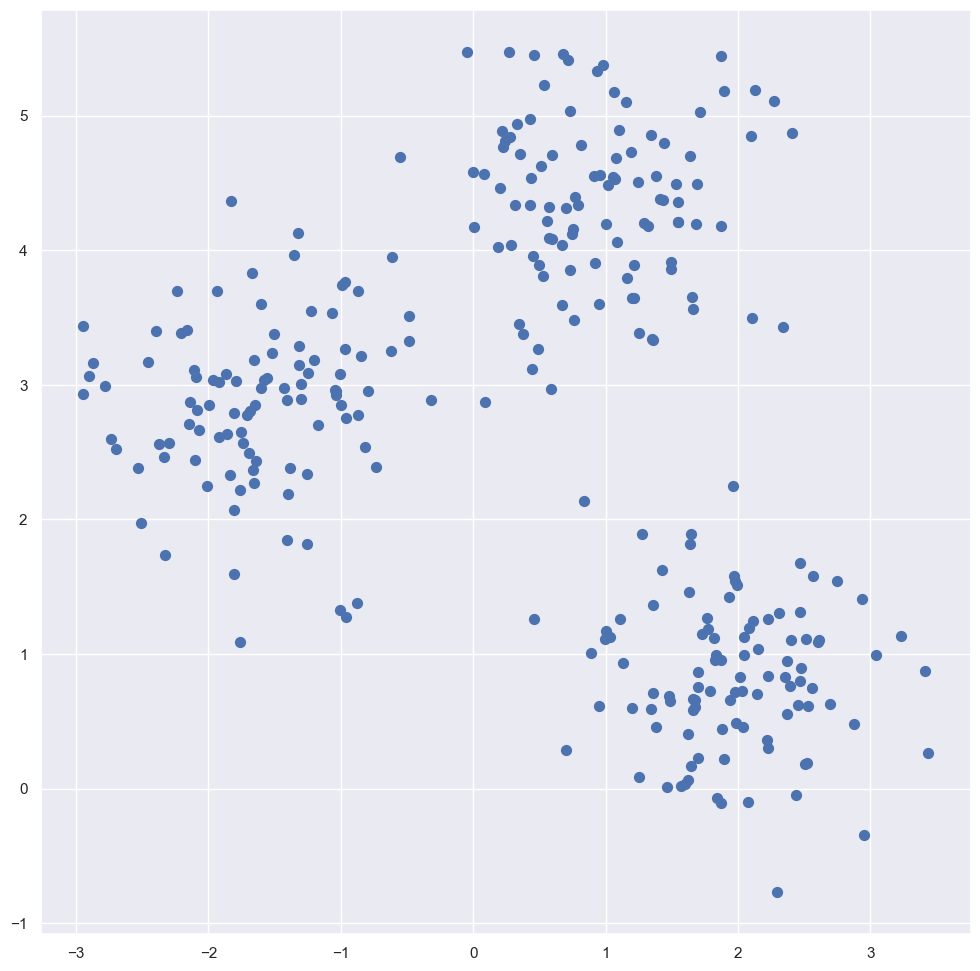

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
from sklearn.datasets import make_blobs

# Comencemos creando 3 grupos de puntos
X, y_true = make_blobs(n_samples=300, centers=3,
                       cluster_std=0.60, random_state=0)
plt.figure(figsize=(12, 12))
plt.scatter(X[:, 0], X[:, 1], s=50);

Calcular las distancias y asignar las etiquetas:

In [5]:
# Scipy tiene una función que toma 2 tuplas y devuelve
# la distancia entre ellas
from scipy.spatial.distance import cdist

# Asigmar aleatoriamente los 3 centroides 
np.random.seed(seed=42)
centroides = np.random.normal(loc=0.0, scale=1., size=6)
centroides = centroides.reshape((3, 2))

cent_historia = []
cent_historia.append(centroides)

for i in range(3):
    # Calcular la distancia entre un punto y un centroide
    distancias = cdist(X, centroides)
    # Chequear cual es el centride más cercano al punto
    etiquetas = distancias.argmin(axis=1)
    
    # Etiquetar el punto de acuerdo a la distancia 
    centroides = centroides.copy()
    centroides[0, :] = np.mean(X[etiquetas == 0, :], axis=0)
    centroides[1, :] = np.mean(X[etiquetas == 1, :], axis=0)
    centroides[2, :] = np.mean(X[etiquetas == 2, :], axis=0)
    
    cent_historia.append(centroides)

Visualizar el algoritmo k-means

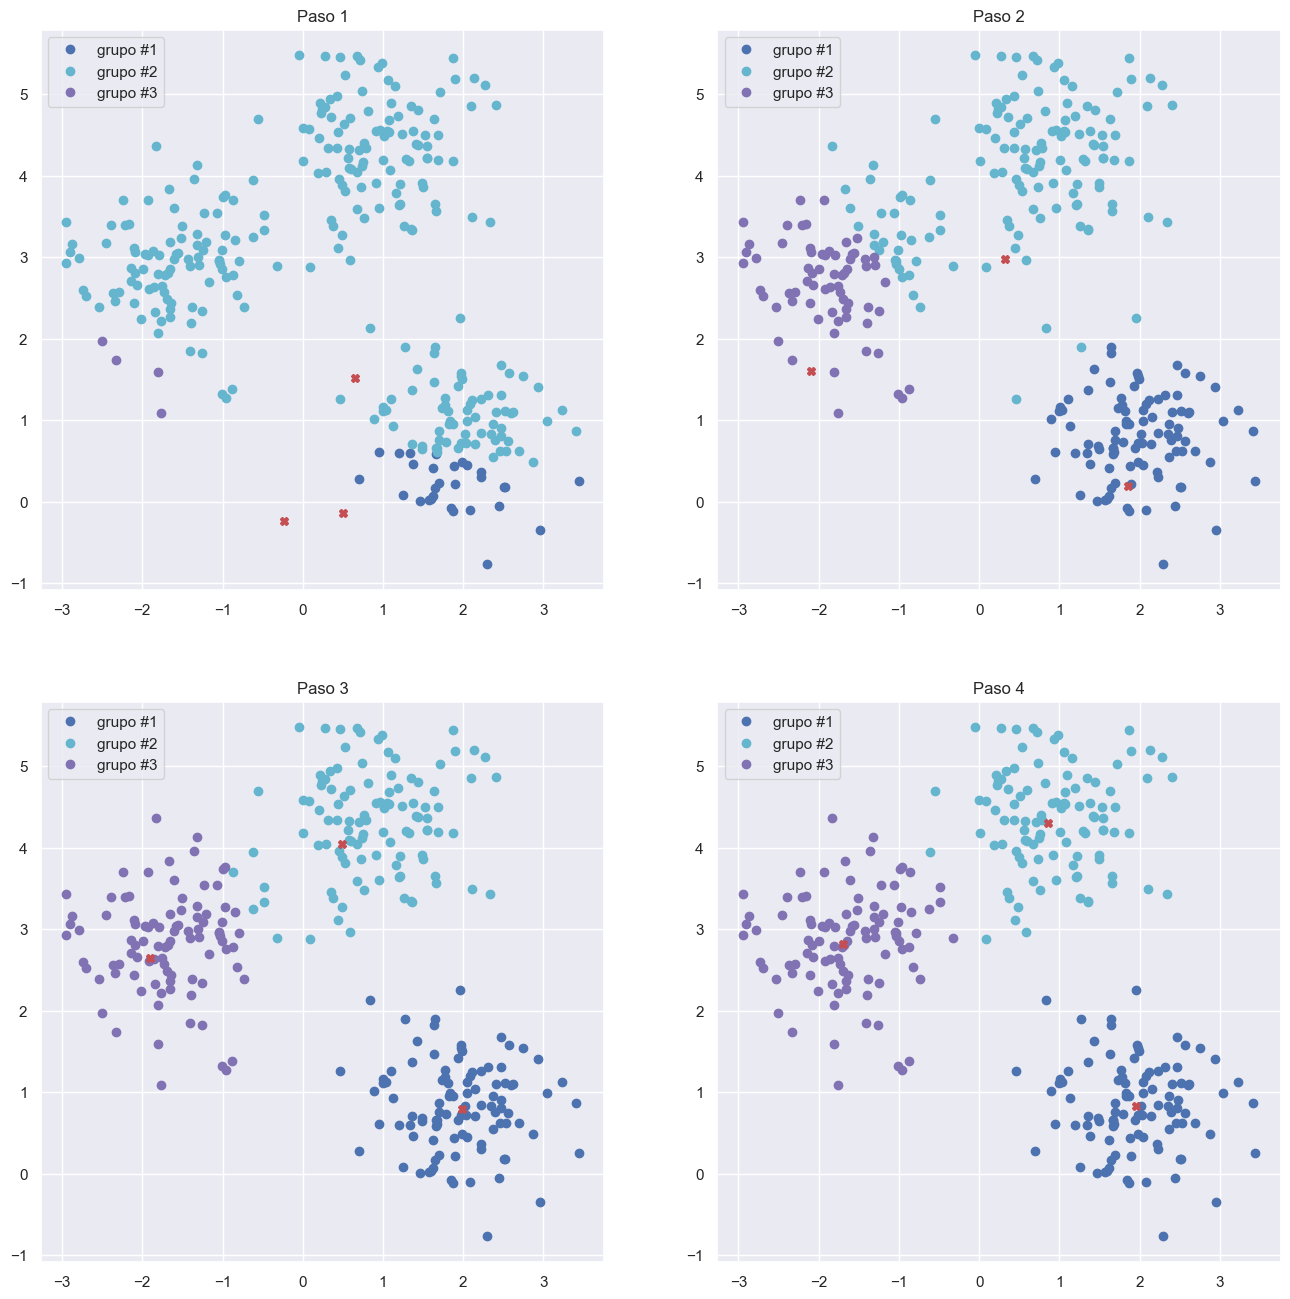

In [6]:
# Graficar K-means
plt.figure(figsize=(16, 16))
for i in range(4):
    distancias = cdist(X, cent_historia[i])
    etiquetas = distancias.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[etiquetas == 0, 0], X[etiquetas == 0, 1], 'bo', label='grupo #1')
    plt.plot(X[etiquetas == 1, 0], X[etiquetas == 1, 1], 'co', label='grupo #2')
    plt.plot(X[etiquetas == 2, 0], X[etiquetas == 2, 1], 'mo', label='grupo #3')
    plt.plot(cent_historia[i][:, 0], cent_historia[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Paso {:}'.format(i + 1));

### Elegir la cantidad de clusters para K-means

A diferencia de las tareas de aprendizaje supervisadas, como la clasificación y la regresión, la agrupación requiere más esfuerzo para elegir el criterio de optimización. Por lo general, cuando trabajamos con k-means, optimizamos la suma de las distancias cuadradas entre las observaciones y sus centroides.

$$J(C)=\sum_{k=1}^K\sum_{i{\in}C_k}{\parallel}x_i-\mu_k\parallel^2$$

Un método para validar la cantidad de grupos es el método del codo. La idea del método de codo es ejecutar k-means sobre el conjunto de datos para un rango de valores de $k$ (digamos, $k$ de 1 a 7) y para cada valor de $k$ calcular la suma de errores cuadrados (SSE).

Luego, graficar la línea de la SSE para cada valor de $k$. Si el gráfico de líneas se ve como un brazo, entonces el "codo" en el brazo es el valor de $k$ que es el mejor. La idea es que queremos un SSE pequeño, pero que el SSE tiende a disminuir hacia 0 a medida que aumentamos $k$ (el SSE es 0 cuando $k$ es igual al número de puntos de datos en el conjunto de datos, porque cada punto de datos es el suyo clúster, y no hay ningún error entre él y el centro de su clúster). Entonces, nuestro objetivo es elegir un valor pequeño de $k$ que todavía tenga un SSE bajo, y el codo generalmente representa el punto donde comenzamos a tener rendimientos decrecientes al aumentar $k$.

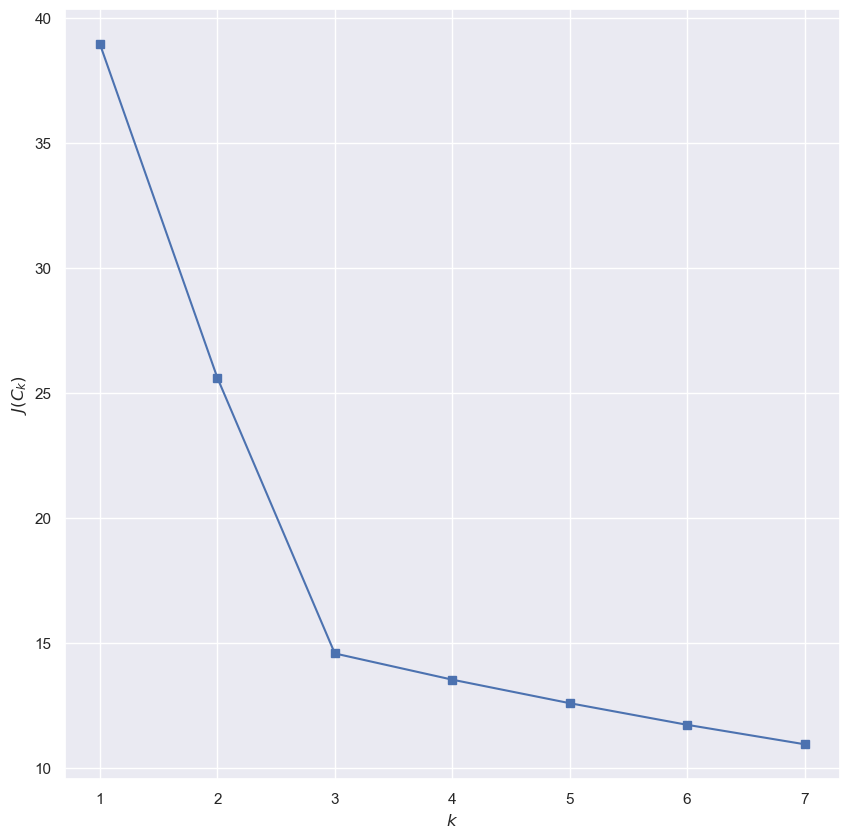

In [9]:
from sklearn.cluster import KMeans
inercia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(X)
    inercia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10, 10))
plt.plot(range(1, 8), inercia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## Ejemplo 1: k-means sobre el conjunto de datos de dígitos

Aquí intentaremos usar k-means para tratar de identificar dígitos similares sin usar la información original de la etiqueta; esto podría ser similar a un primer paso para extraer significado de un nuevo conjunto de datos sobre el cual no se tiene información a priori de la etiqueta.

Comenzaremos por cargar los dígitos y luego encontrar los grupos de KMeans. Recuerde que los dígitos constan de 1.797 muestras con 64 atributos, donde cada una de los 64 atributos es el brillo de un píxel en una imagen de 8 × 8:

In [10]:
from sklearn.datasets import load_digits
digitos = load_digits()
digitos.data.shape

(1797, 64)

La agrupación se puede realizar como lo hicimos antes:

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
grupos = kmeans.fit_predict(digitos.data)
kmeans.cluster_centers_.shape

(10, 64)

El resultado es 10 grupos con 64 dimensiones. Observe que los centros de los grupos en sí son puntos de 64 dimensiones, y pueden interpretarse ellos mismos como el dígito "típico" dentro del clúster. Veamos cómo son estos centros de clúster:

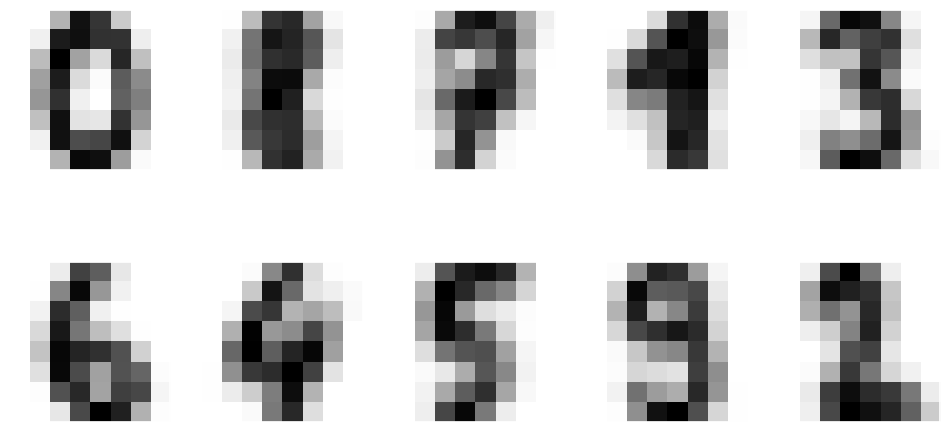

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
centros = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, centro in zip(ax.flat, centros):
    axi.set(xticks=[], yticks=[])
    axi.imshow(centro, interpolation='nearest', cmap=plt.cm.binary)

Vemos que, incluso sin las etiquetas, `KMeans` puede encontrar agrupaciones cuyos centros son dígitos reconocibles, con la posible excepción de 1 y 8.

Debido a que k-means no sabe nada sobre la identidad del grupo, las etiquetas 0-9 pueden ser permutadas. Podemos solucionar esto haciendo coincidir cada etiqueta del grupo aprendido con las etiquetas verdaderas que se encuentran en ellas:

In [14]:
from scipy.stats import mode

etiquetas = np.zeros_like(grupos)
for i in range(10):
    mascara = (grupos == i)
    etiquetas[mascara] = mode(digitos.target[mascara])[0]

Ahora podemos verificar qué tan preciso fue nuestro agrupamiento sin supervisión para encontrar dígitos similares dentro de los datos:

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digitos.target, etiquetas)

0.7918753478018921

¡Con solo un algoritmo de k-means simple, descubrimos la agrupación correcta para el 80% de los dígitos de entrada! Revisemos la matriz de confusión:

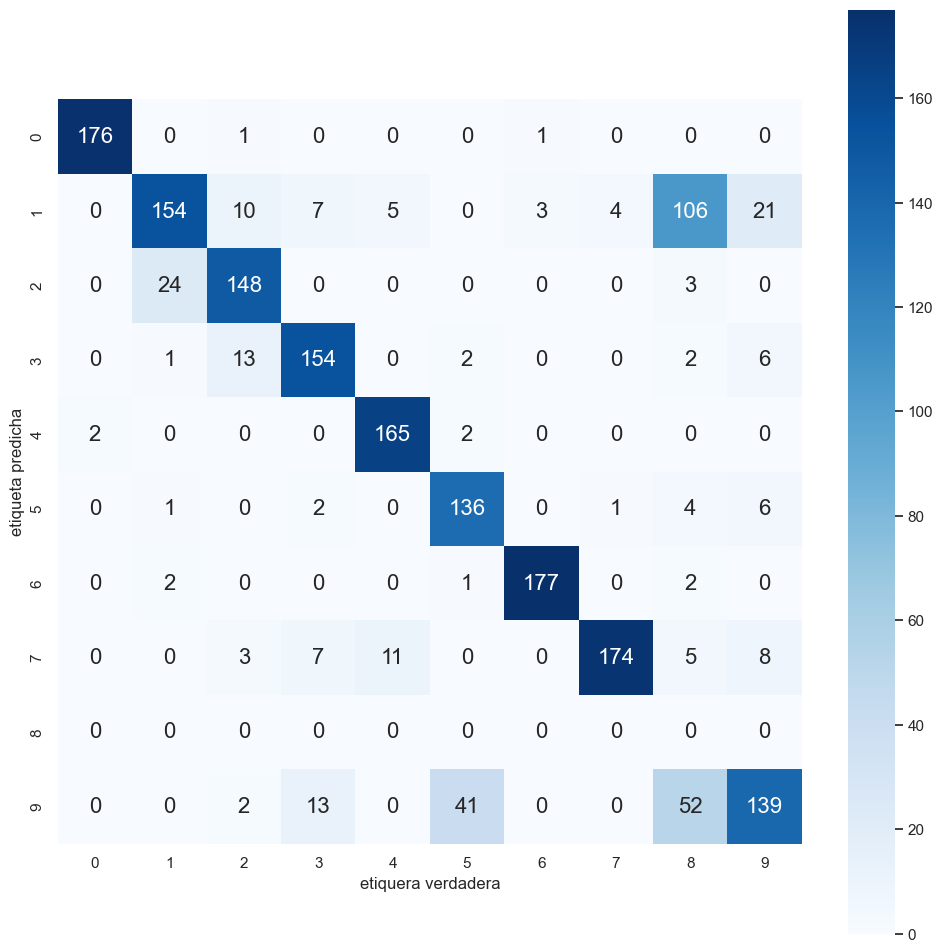

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digitos.target, etiquetas)
plt.figure(figsize=(12, 12))
sns.heatmap(mat.T, square=True, annot=True, annot_kws={"size": 16}, fmt='d', cbar=True, cmap="Blues",
            xticklabels=digitos.target_names,
            yticklabels=digitos.target_names)
plt.xlabel('etiquera verdadera')
plt.ylabel('etiqueta predicha');

Como era de esperarse de los centros de grupos que visualizamos anteriormente, el principal punto de confusión se encuentra entre los ochos y los uno. ¡Pero esto todavía muestra que usando k-means, podemos esencialmente construir un clasificador de dígitos sin referencia a ninguna etiqueta conocida!

## Ejemplo 1: k-means sobre el conjunto de datos de vinos

Durante este ejercicioe usaremos un conjunto de datos que contiene información sobre vinos. Queremos descubrir grupos de diferentes tipos de vino, y tenemos datos sobre las características químicas de los vinos. Los datos son el resultado del análisis químico de vinos cultivados en la misma región en Toscana, Italia, pero derivados de diferentes viñedos. El análisis determinó las cantidades de 13 componentes encontrados en cada vino. Queremos ver si podemos detectar patrones en los datos, de modo que podamos agrupar los vinos en distintos tipos.

In [17]:
import pandas as pd
from sklearn.datasets import load_wine

In [18]:
vinos = load_wine()
vinos.data.shape

(178, 13)

Nombre de los atributos:

In [19]:
vinos.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

Nombre de las etiquetas:

In [20]:
vinos.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

### Exploración de los datos

Tenemos 178 vinos diferentes, y tenemos 13 atributos diferentes, es decir, medidas químicas en ellos. Antes de sumergirnos en la agrupación, hagamos un poco de exploración de nuestros datos para ver si hay cosas que parecen extrañas/sospechosas, etc. Podría comenzar haciendo lo siguiente:

In [21]:
vinos_df = pd.DataFrame(vinos.data)
vinos_df.columns = vinos.feature_names
vinos_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Obtener una tabla de estadísticas de resumen puede parecer un buen punto de partida, pero en realidad no es muy informativo con solo echarle un vistazo. Podría ser una mejor idea crear algunos gráficos informativos. Antes de hacer eso, queremos transformar nuestros datos en una matriz NumPy.

### Gráficos de puntos

En la siguiente celda crearemos un grupo de gráficos. Estas son diagramas de dispersión bi-variados de los atributos individuales de los datos. Obtendremos una idea de cómo los atributos se relacionan entre sí, y podríamos ser capaces de ver las correlaciones entre los atributos.

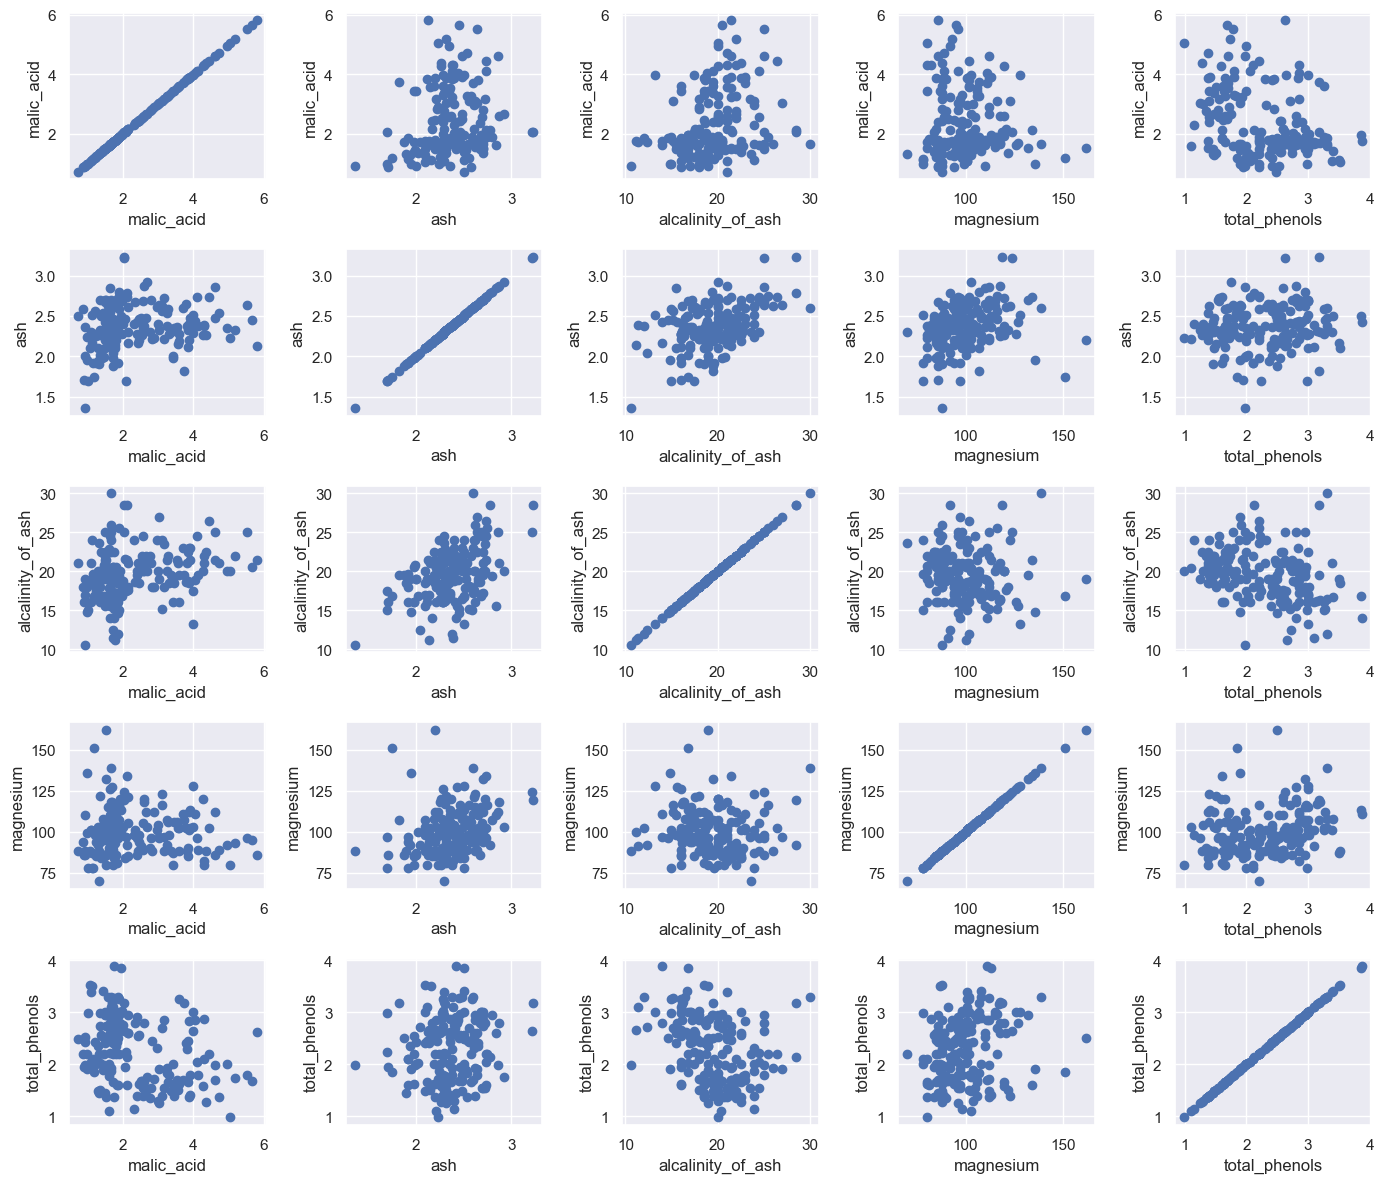

In [22]:
# almacenar los atributos en una matrix X
X = np.array(vinos.data).astype(float)

# almacenar los nombres de las columnas
encabezado = vinos.feature_names

# seleccionar 5 atributos
fig = plt.figure(figsize=(14,12))
atributos_1 = [1,2,3,4,5]
atributos_2 = [1,2,3,4,5]

# calcular la transpuesta de X
matrix_atributos = [X[:,j] for j in range(len(encabezado))]

num_atributos = len(atributos_1)

for j in range(num_atributos):
    for k in range(num_atributos):
        plt.subplot(num_atributos, num_atributos, j + 1 + k * num_atributos)
        plt.scatter(matrix_atributos[atributos_1[j]], matrix_atributos[atributos_2[k]])
        plt.xlabel(encabezado[atributos_1[j]])
        plt.ylabel(encabezado[atributos_2[k]])
        fig.tight_layout()

### Diagramas de Caja (Boxplot)

También podemos hacer que el comando df.describe () sea un poco más fácil para el ojo. Podría, por ejemplo, trazar diagrama de caja de cada atributo en la mismo gráfico, para que pueda ver visualmente cosas como promedios, valores atípicos, distribuciones, etc. de una vez. Vamos a probarlo a continuación

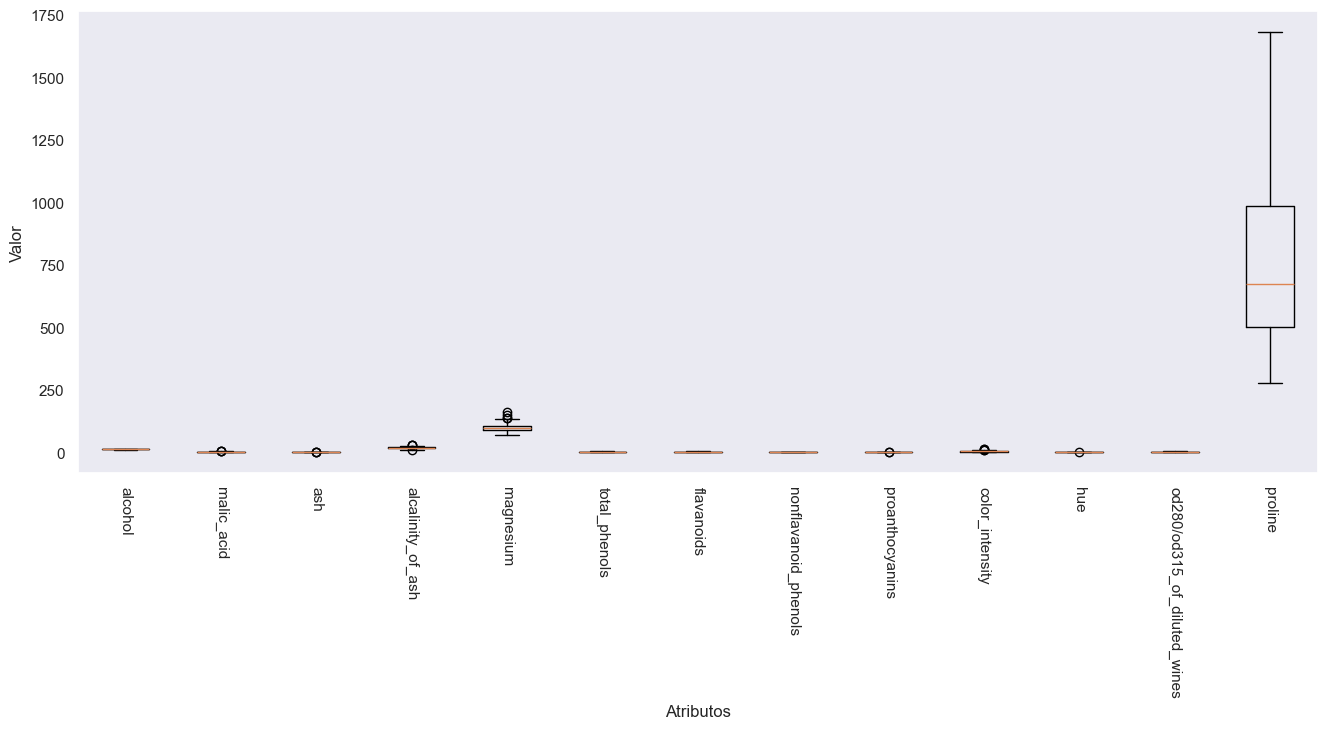

In [23]:
fig, axes = plt.subplots(figsize=(16,6))
bp = plt.boxplot(X)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='o')
plt.xlabel('Atributos')
plt.ylabel('Valor')
axes.set_xticklabels(encabezado, rotation=270)
plt.grid()

### Escalamiento de los atributos

El escalado de atributos es casi siempre necesario si desea ejecutar un algoritmo complejo de aprendizaje automático. Si ignoramos las diferentes escalas, el problema de optimización de aprendizaje automático tardará mucho en resolverse. Para asegurarte de que todos nuestros atributos estén en la misma escala, puedes aplicar una función para escalar los atributos.

In [24]:
from sklearn import preprocessing
escalar  = preprocessing.StandardScaler().fit(X)
X_escalado = escalar.transform(X)

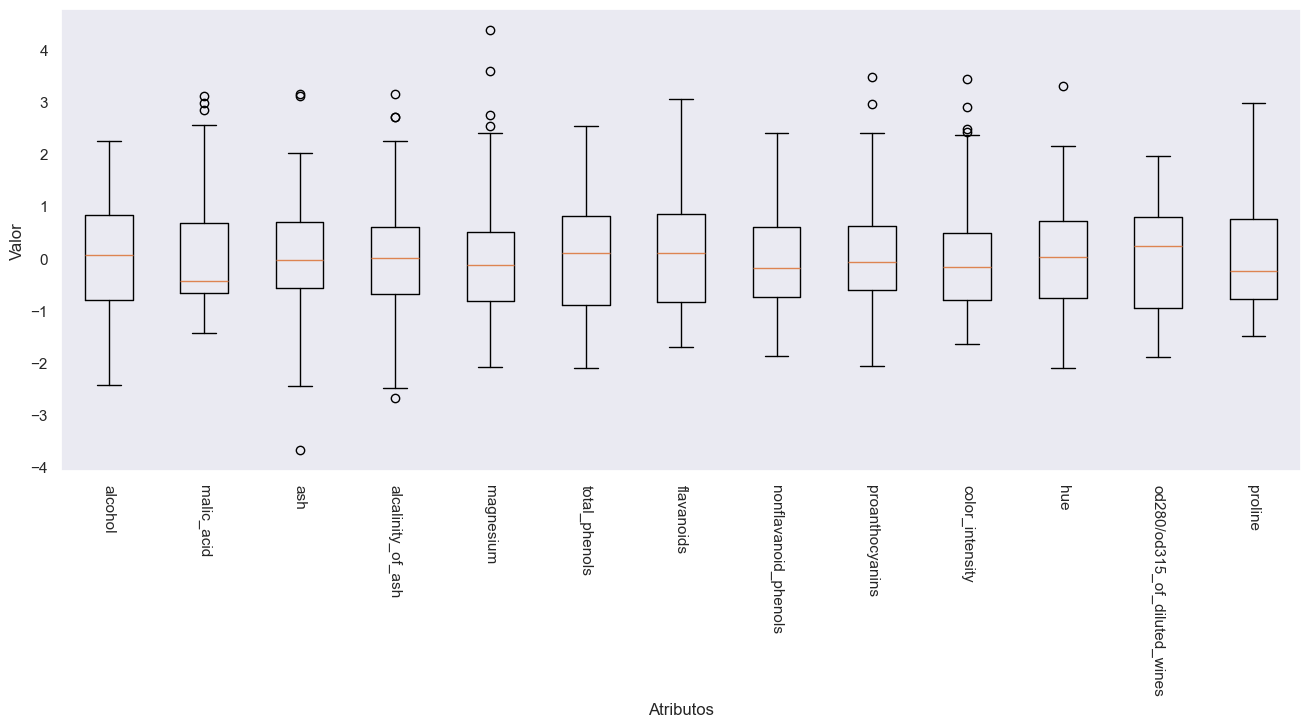

In [25]:
fig, axes = plt.subplots(figsize=(16,6))
bp = plt.boxplot(X_escalado)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='o')
plt.xlabel('Atributos')
plt.ylabel('Valor')
axes.set_xticklabels(encabezado, rotation=270)
plt.grid()

### Conseguir el valor de k usando el método del codo

/Users/wladimir/mambaforge/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wladimir/mambaforge/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wladimir/mambaforge/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wladimir/mambaforge/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

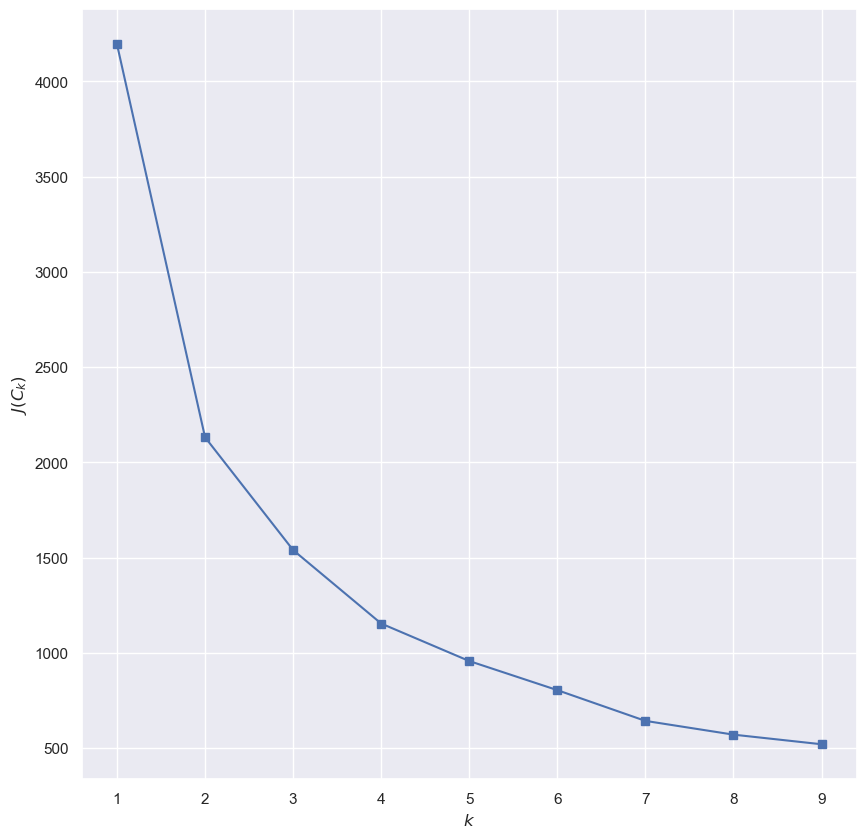

In [26]:
inercia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inercia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10, 10))
plt.plot(range(1, 10), inercia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Podemos ver que el posible valor optimo de k es 3, lo que corresponde con los tres tipos de vinos del conjunto de datos.

In [28]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
clase_vinos = kmeans.fit_predict(vinos.data)

Debido a que k-means no sabe nada sobre la identidad del grupo, las etiquetas `clase_0, clase_1, clase_2` pueden ser permutadas. Podemos solucionar esto haciendo coincidir cada etiqueta del grupo aprendido con las etiquetas verdaderas que se encuentran en ellas:

In [29]:
prediccion = np.zeros_like(clase_vinos)
for i in range(3):
    mascara = (clase_vinos == i)
    prediccion[mascara] = mode(vinos.target[mascara])[0]

Ahora podemos verificar qué tan preciso fue nuestro agrupamiento sin supervisión para encontrar vinos similares dentro de los datos:

In [30]:
accuracy_score(vinos.target, prediccion)

0.702247191011236

¡Con solo un algoritmo de k-means simple, descubrimos la agrupación correcta para el 70% de los vinos de entrada! Revisemos la matriz de confusión:

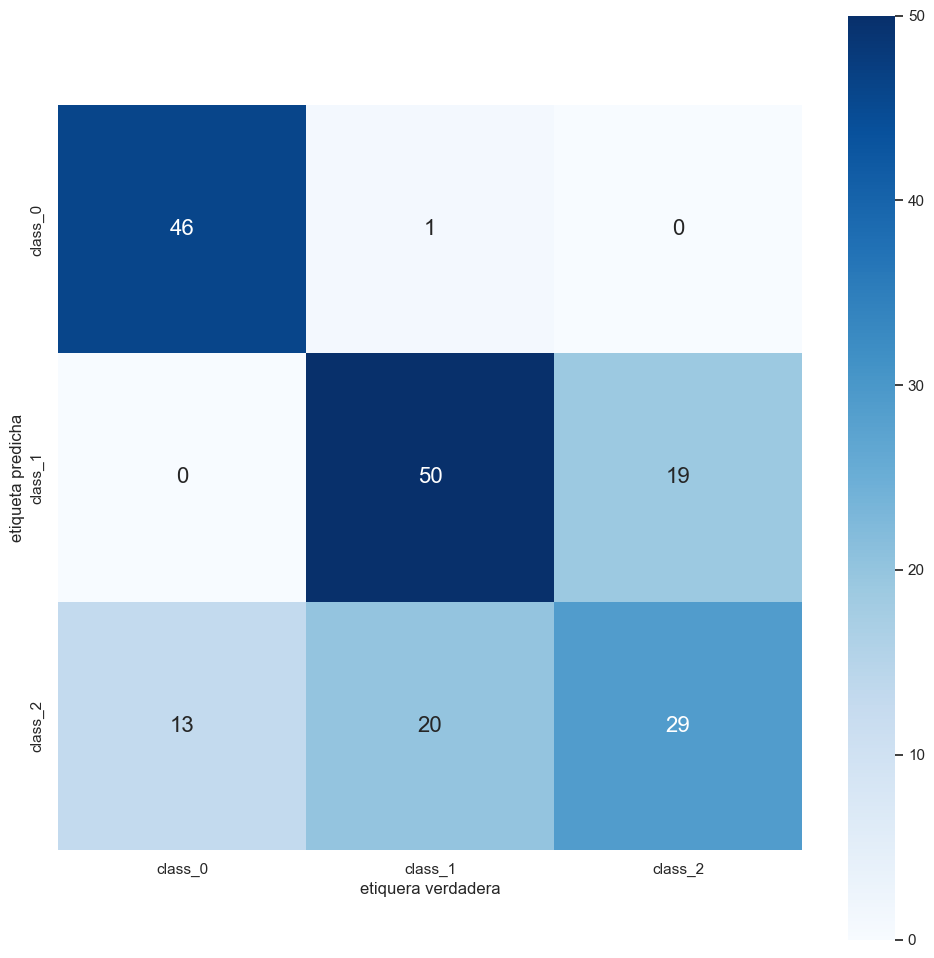

In [31]:
conf_mat = confusion_matrix(vinos.target, prediccion)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_mat.T, square=True, annot=True, annot_kws={"size": 16}, fmt='d', cbar=True, cmap="Blues",
            xticklabels=vinos.target_names,
            yticklabels=vinos.target_names)
plt.xlabel('etiquera verdadera')
plt.ylabel('etiqueta predicha');

El principal punto de confusión se encuentra entre los vinos de la clase_1 y los de la clase_2. ¡Pero esto todavía muestra que usando k-means, podemos esencialmente construir un clasificador para este conjunto de datos de vinos sin referencia a ninguna etiqueta conocida!